In [1]:
import os
from typing import Tuple, List
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from pytorch_msssim import MS_SSIM
import random


In [2]:
class FrameDataset(Dataset):
    def __init__(
        self, dir_names: list[str], root_path: str = "data", max_frames: int = 200
    ):
        self._root_path = root_path
        self._transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )
        self._data = self._get_frames(dir_names, max_frames)

    def _get_frame_triples(self, file_names: list[str]):
        for i in range(len(file_names) - 2):
            yield (file_names[i], file_names[i + 1], file_names[i + 2])

    def _get_frames(
        self, dir_names: list[str], max_frames: int
    ) -> List[Tuple[str, str, str]]:
        frames = []
        for dir_name in dir_names:
            dir_path = os.path.join(self._root_path, dir_name)
            if not os.path.isdir(dir_path):
                print(f"Warning: {dir_path} is not a directory, skipping.")
                continue
            file_names = sorted(
                [
                    f
                    for f in os.listdir(dir_path)
                    if os.path.isfile(os.path.join(dir_path, f))
                    and f.lower().endswith((".png", ".jpg", ".jpeg"))
                ]
            )[:max_frames]
            file_names = [os.path.join(dir_path, file_name) for file_name in file_names]
            frames.extend(self._get_frame_triples(file_names))
        return frames

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._data):
            raise IndexError("Index out of range")
        try:
            img1 = Image.open(self._data[idx][0]).convert("RGB")
            img2 = Image.open(self._data[idx][1]).convert("RGB")
            img3 = Image.open(self._data[idx][2]).convert("RGB")

            img1 = self._transform(img1)
            img2 = self._transform(img2)
            img3 = self._transform(img3)

            return img1, img2, img3
        except Exception as e:
            raise RuntimeError(f"Error loading images at index {idx}: {e}")


In [3]:
def denormalize(tensor: torch.Tensor) -> np.ndarray:
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img = denorm(tensor).permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    return img


def normalize(img: np.ndarray) -> torch.Tensor:
    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1)
    transform = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    return transform(img)


In [4]:
class FrameInterpolationModel(nn.Module):
    def __init__(self):
        super(FrameInterpolationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, frame1, frame3):
        x = torch.cat([frame1, frame3], dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
class PerceptualLoss(nn.Module):
    def __init__(self, layer_indices=[3, 8, 15, 22]):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features.eval()
        self.layers = nn.Sequential(*list(vgg)[: max(layer_indices) + 1])
        self.layer_indices = layer_indices
        for param in self.layers.parameters():
            param.requires_grad = False

        self.register_buffer(
            "mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        )
        self.register_buffer(
            "std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        )

    def normalize(self, x):
        return (x - self.mean) / self.std

    def forward(self, pred, target):
        pred = self.normalize(pred)
        target = self.normalize(target)
        pred_features = []
        target_features = []

        for i, layer in enumerate(self.layers):
            pred = layer(pred)
            target = layer(target)
            if i in self.layer_indices:
                pred_features.append(pred)
                target_features.append(target)

        loss = 0.0
        for pred_f, target_f in zip(pred_features, target_features):
            loss += nn.MSELoss()(pred_f, target_f)
        return loss / len(pred_features)


In [6]:
def calculate_psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img1 = img1.cpu()
    img2 = img2.cpu()
    img1 = denorm(img1).clamp(0, 1)
    img2 = denorm(img2).clamp(0, 1)
    img1_np = (img1.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img2_np = (img2.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float("inf")
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
    return psnr


In [7]:
def train_model(
    model, train_dataset, val_dataset, num_epochs=100, batch_size=8, learning_rate=0.001
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion_pixel = nn.L1Loss()
    criterion_perceptual = PerceptualLoss().to(device)
    criterion_ms_ssim = MS_SSIM(data_range=1.0, size_average=True, channel=3).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for frame1, frame2, frame3 in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]"
        ):
            frame1, frame2, frame3 = (
                frame1.to(device),
                frame2.to(device),
                frame3.to(device),
            )
            optimizer.zero_grad()
            outputs = model(frame1, frame3)

            loss_pixel = criterion_pixel(outputs, frame2)
            loss_perceptual = criterion_perceptual(outputs, frame2)
            loss_ms_ssim = 1 - criterion_ms_ssim(outputs, frame2)
            loss = 1.0 * loss_pixel + 0.1 * loss_perceptual + 0.5 * loss_ms_ssim

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * frame1.size(0)

        train_loss /= len(train_dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frame1, frame2, frame3 in tqdm(
                val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]"
            ):
                frame1, frame2, frame3 = (
                    frame1.to(device),
                    frame2.to(device),
                    frame3.to(device),
                )
                outputs = model(frame1, frame3)
                loss_pixel = criterion_pixel(outputs, frame2)
                loss_perceptual = criterion_perceptual(outputs, frame2)
                loss = 1.0 * loss_pixel + 0.1 * loss_perceptual
                val_loss += loss.item() * frame1.size(0)

        val_loss /= len(val_dataset)
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "frame_interpolation_model.pth")
            print(f"Best model saved with Val Loss: {best_val_loss:.6f}")


In [ ]:
def load_model(
    model: nn.Module, path: str = "frame_interpolation_model.pth"
) -> nn.Module:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()
    return model


In [9]:
def visualize_triplets(
    triplets: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]],
    interpolated_frames: List[torch.Tensor],
    psnr_values_interpolated: List[float],
    psnr_values_gt: List[float],
    num_triplets: int,
    title: str = "Frame Interpolation Comparison",
) -> None:
    """Visualize multiple triplets and their interpolated frames in a single grid plot."""
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))

    num_display = min(num_triplets, len(triplets))
    fig, axes = plt.subplots(num_display, 4, figsize=(16, 4 * num_display))
    fig.suptitle(title, fontsize=16)

    for i in range(num_display):
        frame1, frame2, frame3 = [
            denorm(img).permute(1, 2, 0).cpu().numpy() for img in triplets[i]
        ]
        interpolated = interpolated_frames[i].cpu()
        img_interpolated = denorm(interpolated).permute(1, 2, 0).cpu().numpy()

        ax_row = axes[i] if num_display > 1 else axes

        ax_row[0].imshow(frame1)
        ax_row[0].set_title("Frame 1")
        ax_row[0].axis("off")

        ax_row[1].imshow(frame2)
        ax_row[1].set_title(f"Ground Truth (PSNR: {psnr_values_gt[i]:.2f} dB)")
        ax_row[1].axis("off")

        ax_row[2].imshow(frame3)
        ax_row[2].set_title("Frame 3")
        ax_row[2].axis("off")

        ax_row[3].imshow(img_interpolated)
        ax_row[3].set_title(
            f"Interpolated (PSNR: {psnr_values_interpolated[i]:.2f} dB)"
        )
        ax_row[3].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [10]:
def test_model(model, test_dataset, num_triplets=10, visualize=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    psnr_values_interpolated = []
    psnr_values_gt = []
    triplets_to_visualize = []
    interpolated_frames = []

    for i, (frame1, frame2, frame3) in enumerate(test_loader):
        if i >= num_triplets:
            break
        frame1, frame2, frame3 = frame1.to(device), frame2.to(device), frame3.to(device)
        with torch.no_grad():
            interpolated_frame = model(frame1, frame3).squeeze(0)

            frame_avg = (frame1 + frame3) / 2.0

        psnr_interpolated = calculate_psnr(interpolated_frame, frame2.squeeze(0))
        psnr_values_interpolated.append(psnr_interpolated)

        psnr_gt = calculate_psnr(frame2.squeeze(0), frame_avg.squeeze(0))
        psnr_values_gt.append(psnr_gt)
        print(
            f"Triplet {i + 1}/{min(num_triplets, len(test_dataset))}: "
            f"Interpolated PSNR = {psnr_interpolated:.2f} dB, "
            f"Ground Truth PSNR = {psnr_gt:.2f} dB"
        )

        if visualize:
            triplets_to_visualize.append(
                (frame1.squeeze(0), frame2.squeeze(0), frame3.squeeze(0))
            )
            interpolated_frames.append(interpolated_frame)

    mean_psnr_interpolated = (
        np.mean(psnr_values_interpolated) if psnr_values_interpolated else 0
    )
    std_psnr_interpolated = (
        np.std(psnr_values_interpolated) if psnr_values_interpolated else 0
    )
    mean_psnr_gt = np.mean(psnr_values_gt) if psnr_values_gt else 0
    std_psnr_gt = np.std(psnr_values_gt) if psnr_values_gt else 0
    print(f"\nNumber of triplets evaluated: {len(psnr_values_interpolated)}")
    print(f"Average Interpolated PSNR: {mean_psnr_interpolated:.2f} dB")
    print(f"Standard Deviation of Interpolated PSNR: {std_psnr_interpolated:.2f} dB")
    print(f"Average Ground Truth PSNR: {mean_psnr_gt:.2f} dB")
    print(f"Standard Deviation of Ground Truth PSNR: {std_psnr_gt:.2f} dB")

    if visualize and triplets_to_visualize:
        visualize_triplets(
            triplets_to_visualize,
            interpolated_frames,
            psnr_values_interpolated,
            psnr_values_gt,
            num_triplets,
        )


10 1 1
Train dataset size: 1980
Validation dataset size: 198
Test dataset size: 198


/home/irek/Development/SIGK/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/irek/Development/SIGK/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20 [Val]: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


Epoch 1/20, Train Loss: 0.314892, Val Loss: 0.167840
Best model saved with Val Loss: 0.167840


Epoch 2/20 [Val]: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Epoch 2/20, Train Loss: 0.214105, Val Loss: 0.160179
Best model saved with Val Loss: 0.160179


Epoch 3/20 [Val]: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Epoch 3/20, Train Loss: 0.203091, Val Loss: 0.153827
Best model saved with Val Loss: 0.153827


Epoch 4/20 [Val]: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


Epoch 4/20, Train Loss: 0.197957, Val Loss: 0.166121


Epoch 5/20 [Val]: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Epoch 5/20, Train Loss: 0.193119, Val Loss: 0.143818
Best model saved with Val Loss: 0.143818


Epoch 6/20 [Val]: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


Epoch 6/20, Train Loss: 0.188130, Val Loss: 0.144708


Epoch 7/20 [Val]: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


Epoch 7/20, Train Loss: 0.184807, Val Loss: 0.148865


Epoch 8/20 [Val]: 100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


Epoch 8/20, Train Loss: 0.185524, Val Loss: 0.149873


Epoch 9/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Epoch 9/20, Train Loss: 0.178429, Val Loss: 0.140577
Best model saved with Val Loss: 0.140577


Epoch 10/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Epoch 10/20, Train Loss: 0.178611, Val Loss: 0.142479


Epoch 11/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Epoch 11/20, Train Loss: 0.177007, Val Loss: 0.140068
Best model saved with Val Loss: 0.140068


Epoch 12/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Epoch 12/20, Train Loss: 0.173584, Val Loss: 0.167609


Epoch 13/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Epoch 13/20, Train Loss: 0.170819, Val Loss: 0.139005
Best model saved with Val Loss: 0.139005


Epoch 14/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


Epoch 14/20, Train Loss: 0.169743, Val Loss: 0.135558
Best model saved with Val Loss: 0.135558


Epoch 15/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Epoch 15/20, Train Loss: 0.169445, Val Loss: 0.134861
Best model saved with Val Loss: 0.134861


Epoch 16/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Epoch 16/20, Train Loss: 0.167811, Val Loss: 0.132639
Best model saved with Val Loss: 0.132639


Epoch 17/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Epoch 17/20, Train Loss: 0.165501, Val Loss: 0.134314


Epoch 18/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


Epoch 18/20, Train Loss: 0.166167, Val Loss: 0.133065


Epoch 19/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Epoch 19/20, Train Loss: 0.164847, Val Loss: 0.147315


Epoch 20/20 [Val]: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Epoch 20/20, Train Loss: 0.163273, Val Loss: 0.135860
Triplet 1/10: Interpolated PSNR = 37.94 dB, Ground Truth PSNR = 39.03 dB
Triplet 2/10: Interpolated PSNR = 38.31 dB, Ground Truth PSNR = 39.48 dB
Triplet 3/10: Interpolated PSNR = 37.42 dB, Ground Truth PSNR = 38.33 dB
Triplet 4/10: Interpolated PSNR = 38.35 dB, Ground Truth PSNR = 39.04 dB
Triplet 5/10: Interpolated PSNR = 38.75 dB, Ground Truth PSNR = 39.90 dB
Triplet 6/10: Interpolated PSNR = 37.37 dB, Ground Truth PSNR = 38.24 dB
Triplet 7/10: Interpolated PSNR = 39.80 dB, Ground Truth PSNR = 41.71 dB
Triplet 8/10: Interpolated PSNR = 37.07 dB, Ground Truth PSNR = 37.95 dB
Triplet 9/10: Interpolated PSNR = 37.77 dB, Ground Truth PSNR = 38.46 dB
Triplet 10/10: Interpolated PSNR = 39.57 dB, Ground Truth PSNR = 41.48 dB

Number of triplets evaluated: 10
Average Interpolated PSNR: 38.23 dB
Standard Deviation of Interpolated PSNR: 0.87 dB
Average Ground Truth PSNR: 39.36 dB
Standard Deviation of Ground Truth PSNR: 1.25 dB


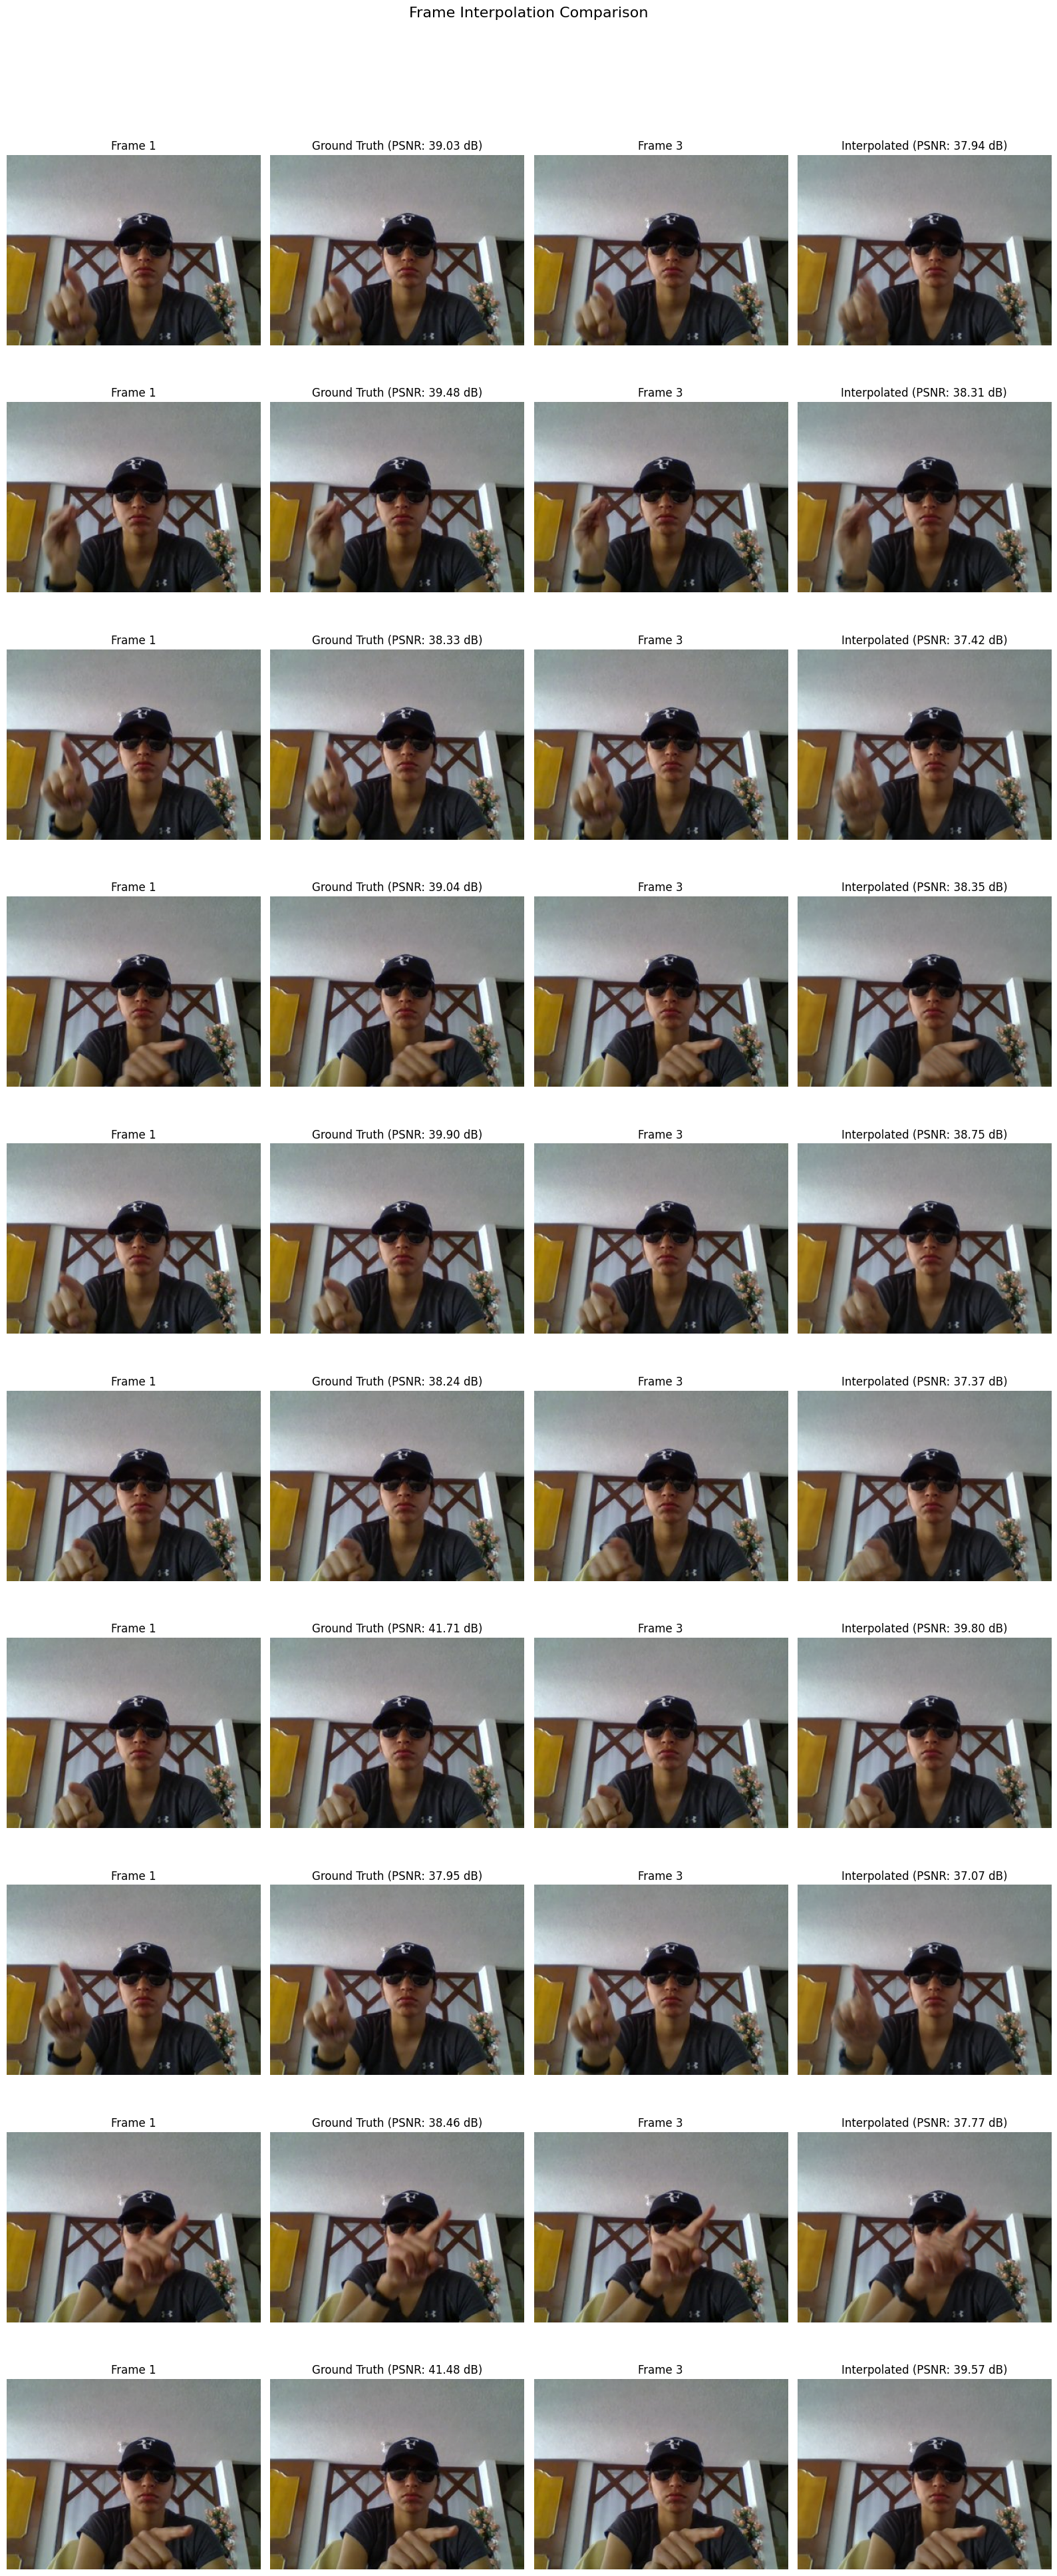

In [11]:
data_dirs = os.listdir("data")
if len(data_dirs) < 2:
    raise ValueError(
        "At least two directories are required for validation and test sets."
    )

val_dir = [data_dirs[0]]
train_dir = data_dirs[1:11]
test_dir = [random.choice(data_dirs[11:])]
print(len(train_dir), len(val_dir), len(test_dir))

train_dataset = FrameDataset(train_dir, max_frames=200)
val_dataset = FrameDataset(val_dir, max_frames=200)
test_dataset = FrameDataset(test_dir, max_frames=200)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

if len(train_dataset) == 0 or len(val_dataset) == 0 or len(test_dataset) == 0:
    raise ValueError("One or more datasets are empty.")

model = FrameInterpolationModel()
train_model(
    model,
    train_dataset,
    val_dataset,
    num_epochs=20,
    batch_size=4,
    learning_rate=0.001,
)

model = load_model(model)
test_model(model, test_dataset, visualize=True)
